# 데이콘 이상탐지 데이터 분석
---

In [1]:
!pip install --upgrade matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

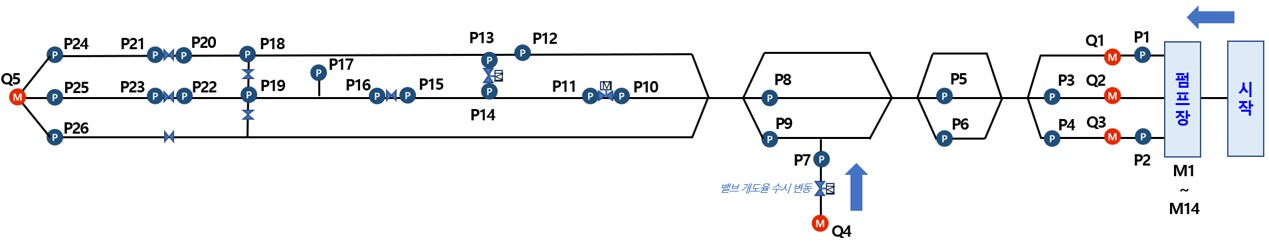

In [3]:
#밸브 개도율 압력계: p7, p10,p11,p13,p14,p15,p16,p18,p19,p20,p21,p22,p23

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

# 데이터 정보

In [4]:
df_A = pd.read_csv("/Users/gimjaeheon/Desktop/k-water2/open/train/TRAIN_A.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)




Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')
칼럼 수 :  73
차원 :  (44101, 73)


In [5]:
def create_leakage_variable(data, structure):
    if structure == 'A':
        return data['Q1'] + data['Q2'] + data['Q3'] + data['Q4'] - data['Q5']
    elif structure == 'B':
        return data['Q1'] - (data['Q2'] + data['Q3'] + data['Q4'])
    elif structure == 'C':
        return data['Q1'] - (data['Q2'] + data['Q3'] + data['Q4'] + data['Q5'] + data['Q6'] + data['Q7'] + data['Q8'])
    elif structure == 'D':
        return data['Q1'] - (data['Q2'] + data['Q3'] + data['Q4'] + data['Q5'])
    else:
        return None

def train_structure_classifier(train_A, train_B, train_C, train_D):
    # 특성 추출
    features_A = train_A[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
    features_B = train_B[['Q1', 'Q2', 'Q3', 'Q4']]
    features_C = train_C[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']]
    features_D = train_D[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
    
    # 레이블 생성
    labels_A = ['A'] * len(train_A)
    labels_B = ['B'] * len(train_B)
    labels_C = ['C'] * len(train_C)
    labels_D = ['D'] * len(train_D)
    
    # 데이터 결합
    features = pd.concat([features_A, features_B, features_C, features_D], axis=0)
    labels = labels_A + labels_B + labels_C + labels_D
    
    # 스케일링 및 모델 학습 (이전 코드와 동일)
    
    return clf, scaler



In [6]:
create_leakage_variable(df_A,'A')

0         358.002
1        1210.002
2        -137.000
3        -101.000
4         478.001
           ...   
44096      29.001
44097     528.001
44098    -393.999
44099    1557.003
44100    2169.003
Length: 44101, dtype: float64

In [6]:
# 결과 확인 (처음 5행 출력)
print(df_A[['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'leakage']].head())

      Q1         Q2         Q3    Q4     Q5   leakage
0  17880  37151.001  24834.001  6321  85828   358.002
1  17970  37069.001  25016.001  6367  85212  1210.002
2  17280  37345.000  24462.000  6431  85655  -137.000
3  17280  37345.000  24462.000  6431  85619  -101.000
4  17920  37075.000  24896.001  6206  85619   478.001


`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q5 : 유량 정량 정보
- M1 ~ M14 : 이진 분류되어진 펌프가동정보, 이산형 데이터 0이면 꺼진거 1이면 켜진거
- P1 ~ P26 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P26_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


In [ ]:
###제출파일 만들기 코드
import pandas as pd
import numpy as np

# 예측 결과 불러오기 (예시)
final_results = pd.read_csv('final_results.csv')

# test.csv 파일 불러오기
test_df = pd.read_csv('test.csv')

# 결과를 저장할 DataFrame 생성
submission = pd.DataFrame(columns=['ID', 'flag_list'])

# 각 테스트 케이스에 대해 처리
for _, row in test_df.iterrows():
    id = row['ID']
    path = row['path']
    
    # 관망 구조 확인 (C or D)
    structure = path.split('/')[0]
    
    # 해당 구조의 압력계 개수 확인
    if structure == 'C':
        pressure_cols = [f'P{i}' for i in range(1, 9)]  # P1 ~ P8
    elif structure == 'D':
        pressure_cols = [f'P{i}' for i in range(1, 6)]  # P1 ~ P5
    
    # T+1 시점의 예측 결과 가져오기
    next_timestamp = final_results.index[final_results.index.get_loc(row['timestamp']) + 1]
    flags = final_results.loc[next_timestamp, [f'{col}_flag_pred' for col in pressure_cols]].astype(int).tolist()
    
    # 결과 추가
    submission = submission.append({'ID': id, 'flag_list': flags}, ignore_index=True)

# 결과 저장
submission.to_csv('sample_submission.csv', index=False)


---
# EDA 
- 이상탐지여부 중심으로 진행
- 매우 낮은 이상치 갯수 